# 1 CCF (1 spot)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from matplotlib.pyplot import figure


from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau


from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate

import os
import imageio.v2 as imageio  

## Data

In [2]:
#initial parameters
n = 1000
RV = np.arange(-18000,18001,500)

In [3]:
#initial parameters
na = 1000

In [4]:
data_matrices = {}
for i in range(n):
    filename = f'STARSIM_output_CCFr_{i}.txt'
    data_matrix = np.loadtxt(filename)
    data_matrices[f'd{i}'] = data_matrix

In [5]:
for i in range(na):
    filename = f'STARSIM_output_CCFn_{i}.txt'
    data_matrix = np.loadtxt(filename)
    data_matrices[f'd{i+1000}'] = data_matrix

In [6]:
np.shape(data_matrices['d0'])

(73, 28)

In [6]:
n = 2000

In [7]:
for i in range(n):
    data_matrices[f'd{i}'] = data_matrices[f'd{i}'][:,1:]

In [8]:
for i in range(n):
    data_matrices[f'd{i}'] = data_matrices[f'd{i}'].T

In [9]:
np.shape(data_matrices['d0'])

(27, 73)

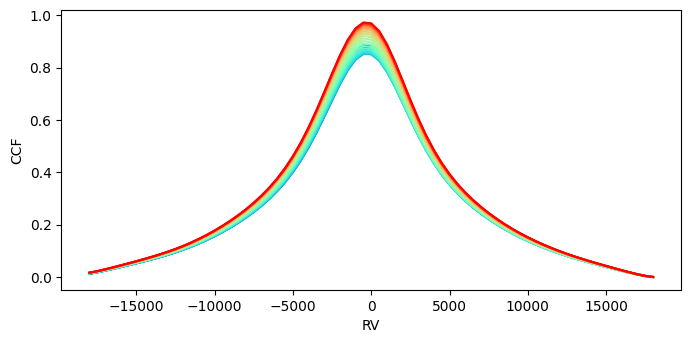

In [9]:
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid((2, 1), (0, 0))
ccf = data_matrices['d3']
jet=plt.get_cmap('rainbow')
colors = iter(jet(np.linspace(0,1,27)))

for j in range(27):
    ax1.plot(RV[:], ccf[j,:], color=next(colors))
    ax1.set_ylabel('CCF')
    ax1.set_xlabel('RV')

Differential

In [9]:
ccf_total = {}

for i in range(n):
    for j in range(73):
        a = 0
        for k in range(27):
            a += data_matrices[f'd{i}'][k,j]
        ccf_total[f'd{i}',j] = a
    

for i in range(n):
    ccf_total1 = np.zeros(73)
    for k in range(27):
        for j in range(73):
            ccf_total1[j] = ccf_total[f'd{i}',j]/27
        for l in range(73):
            data_matrices[f'd{i}'][k,l] = data_matrices[f'd{i}'][k,l]- ccf_total1[l]

            

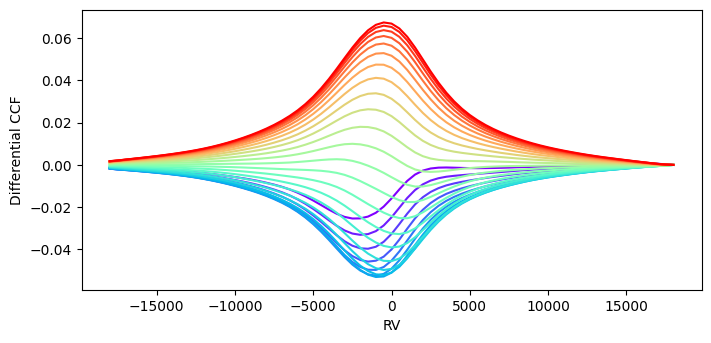

In [11]:
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid((2, 1), (0, 0))
differential = data_matrices['d3']
jet=plt.get_cmap('rainbow')
colors = iter(jet(np.linspace(0,1,27)))

for j in range(27):
    ax1.plot(RV[:], differential[j,:], color=next(colors))
    ax1.set_ylabel('Differential CCF')
    ax1.set_xlabel('RV')

In [112]:
from IPython.display import FileLink
import os
import imageio.v2 as imageio  

image_filenames = []

jet=plt.get_cmap('rainbow')
colors = iter(jet(np.linspace(0,1,27)))

for j in range(27):
  plt.plot(RV[:], differential[j,:], color=next(colors))  
  plt.xlabel('RV')
  plt.ylabel('CCF')
  plt.title(f'Time Step {j}')
  filename = f'plot_{j}.png'
  plt.savefig(filename)
  plt.close() 
  image_filenames.append(filename)
with imageio.get_writer('CCF_original1.gif', mode='I') as writer:
    for filename in image_filenames:
        image = imageio.imread(filename)
        for _ in range(int(2)):
            writer.append_data(image)
for filename in image_filenames:
   os.remove(filename)

In [103]:
FileLink('differential_original1.gif')

C:\Users\jenni\starsim\new_data_1period\1CCF\differential_original1.gif

In [10]:
for i in range(n):
    data_matrices[f'd{i}'] = np.reshape(data_matrices[f'd{i}'],27*73)

In [11]:
n_train = int(n*0.9*0.9)
n_val = int(n*0.1*0.9)
n_test = n-n_train-n_val

train_data = []
val_data = []
test_data = []

In [12]:
for i in range(n_train):
    train_data.append(data_matrices[f'd{i}'])

for i in range(n_train,n_train+n_val,1):
    val_data.append(data_matrices[f'd{i}'])
    
for i in range(n_train+n_val,n,1):
    test_data.append(data_matrices[f'd{i}'])

In [13]:
train_data = np.array(train_data).reshape(n_train,27*73)
val_data = np.array(val_data).reshape(n_val,27*73)
test_data = np.array(test_data).reshape(n-n_train-n_val, 27*73)

In [54]:
np.shape(train_data)

(1620, 1971)

## 1 CCF as input data

In [14]:
train_data1 = []
test_data1 = []
val_data1 = []

In [15]:
for i in range(n_train):
    for j in range(0,1096,73):
        train_data1.append(train_data[i,j:j+73]) #agafem 15 CCFs, de 73 punts
        
for i in range(n_test):
    for j in range(0,1096,73):
        test_data1.append(test_data[i,j:j+73])
        
for i in range(n_val):
    for j in range(0, 1096,73):
        val_data1.append(val_data[i,j:j+73])


In [16]:
maxim = np.mean(np.max(np.abs(train_data), axis=1))

In [17]:
train_data1 = np.array(train_data1/maxim).reshape(n_train*16,73,1)
test_data1 = np.array(test_data1/maxim).reshape(n_test*16,73,1)
val_data1 = np.array(val_data1/maxim).reshape(n_val*16,73,1)

In [97]:
np.shape(val_data1)

(2880, 73, 1)

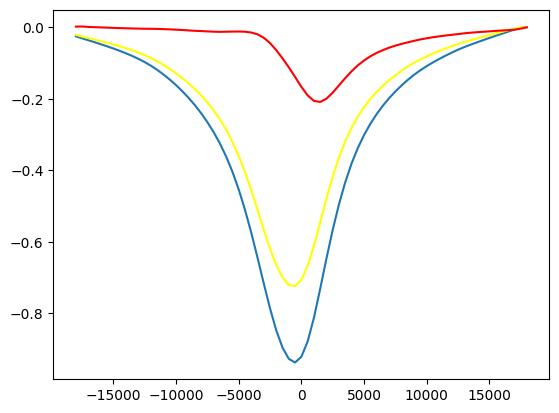

In [52]:
plt.plot(RV, train_data1[12310,:])
plt.plot(RV, train_data1[4,:],color='yellow')
plt.plot(RV, train_data1[2030,:], color='red')

## Autoencoder

In [ ]:
input_shape = (73,1)

latent_dim=70
class Autoencoder(Model):
    def __init__(self, input_shape, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            #block1
            layers.Input(batch_shape=(None,73,1)),
            layers.Conv1D(32, kernel_size=3, activation='tanh', padding='same'),
            #block3
            layers.Conv1D(32, kernel_size=3, activation='tanh', padding='same'),
            #final
            layers.Flatten(),
            layers.Dense(64, activation='tanh'),
            layers.Dense(latent_dim, activation='tanh'),
        ])
        
        self.decoder = tf.keras.Sequential([
            #block1
            layers.Dense(64, activation='tanh'),
            layers.Dense(73*32, activation='tanh'),
            layers.Reshape((73,32)), 
            #block2
            layers.Conv1D(32, kernel_size=3, activation='tanh', padding='same'),
            #block3
            layers.Conv1D(32, kernel_size=3, activation='tanh', padding='same'),
            #final
            layers.Conv1D(1, kernel_size=3, activation='linear', padding='same')  
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(input_shape, latent_dim=latent_dim)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.0001, patience=5, min_lr=1e-8)

initial_learning_rate = 0.001
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss='mse')

optimizer = tf.keras.optimizers.Adam()


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)


history = autoencoder.fit(train_data1, train_data1,
                          epochs=30,
                          shuffle=True,
                          batch_size=512,
                           callbacks=[reduce_lr, early_stopping], validation_data= [val_data1,val_data1])


1/1 [==============================] - 0s 63ms/step


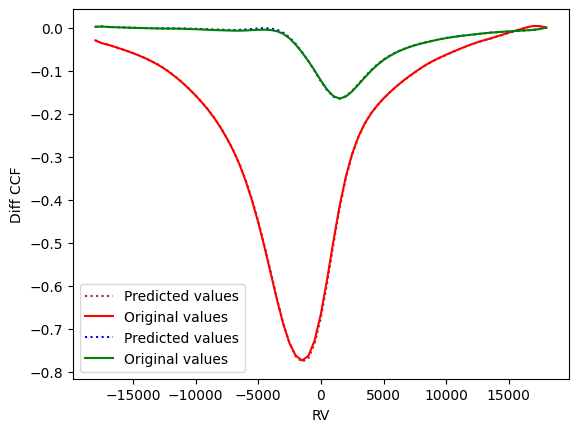

In [125]:
predictions = autoencoder.predict(test_data1[1:2,:])
plt.plot(RV, predictions[0,:,0], color='brown', linestyle='dotted',label = 'Predicted values')
test2 = test_data1[1,:][:,0]
plt.plot(RV, test2, color='red', label= 'Original values')
plt.xlabel('RV')
plt.ylabel('Diff CCF')
predictions2 = autoencoder.predict(test_data1[1037:1038,:])
plt.plot(RV, predictions2[0,:,0], color='blue', linestyle='dotted', label = 'Predicted values')
test3 = test_data1[1037,:][:,0]
plt.plot(RV, test3, color='green', label= 'Original values')
plt.legend()

## Latent space dimension

In [ ]:
input_shape = (73,1)

latent_dims = np.arange(5,20,1)
lossesvec = []

for k in range(len(latent_dims)):
    class Autoencoder(Model):
        def __init__(self, input_shape, latent_dim):
            super(Autoencoder, self).__init__()
            self.latent_dim = latent_dims[k]
            self.encoder = tf.keras.Sequential([
                #block1
                layers.Input(batch_shape=(None,73,1)),
                layers.Conv1D(16, kernel_size=3, activation='tanh', padding='same'),
                #block3
                layers.Conv1D(16, kernel_size=3, activation='tanh', padding='same'),
                #final
                layers.Flatten(),
                layers.Dense(64, activation='tanh'),
                layers.Dense(latent_dims[k], activation='tanh'),
            ])

            self.decoder = tf.keras.Sequential([
                #block1
                layers.Dense(64, activation='tanh'),
                layers.Dense(73*16, activation='tanh'),
                layers.Reshape((73,16)), 
                #block2
                layers.Conv1D(16, kernel_size=3, activation='tanh', padding='same'),
                #block3
                layers.Conv1D(16, kernel_size=3, activation='tanh', padding='same'),
                #final
                layers.Conv1D(1, kernel_size=3, activation='linear', padding='same')  
            ])

        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded


    autoencoder = Autoencoder(input_shape, latent_dim=latent_dims[k])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, min_lr=1e-12)

    initial_learning_rate = 0.001
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  loss='mse')

    optimizer = tf.keras.optimizers.Adam()


    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


    history = autoencoder.fit(train_data1, train_data1,
                              epochs=20,
                              shuffle=True,
                              batch_size=264,
                              validation_data=(val_data1, val_data1),
                               callbacks=[reduce_lr, early_stopping])
    
    losses = history.history['val_loss'][-1]
    lossesvec.append(losses)

Text(0, 0.5, 'Validation loss')

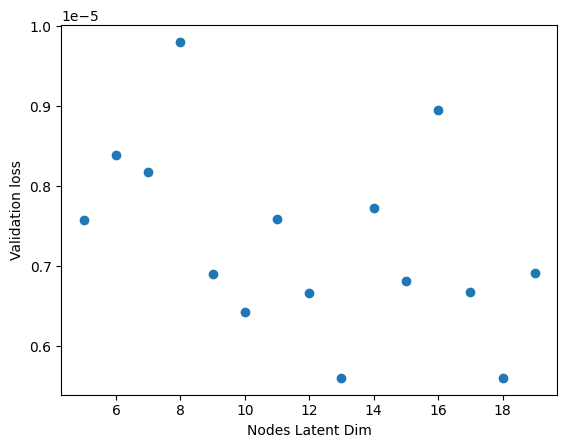

In [127]:
plt.scatter(np.arange(5,20,1), lossesvec)
plt.xlabel('Nodes Latent Dim')
plt.ylabel('Validation loss')

In [ ]:
np.where(lossesvec==np.min(lossesvec))

Latent dimension 13

## Optimising hyper-parameters

In [ ]:
input_shape = (73,1)
latent_dim = 13

nodesfc = [32,64]
filters = [32,64]
kern = [3,5,7]
lossesvec2 = []
for k in range(len(kern)):
    for i in range(len(nodesfc)):
        for j in range(len(filters)):
            class Autoencoder(Model):
                def __init__(self, input_shape, latent_dim):
                    super(Autoencoder, self).__init__()
                    self.latent_dim = latent_dim
                    self.encoder = tf.keras.Sequential([
                        #block1
                        layers.Input(batch_shape=(None,73,1)),
                        layers.Conv1D(filters[j], kernel_size=kern[k], activation='tanh', padding='same'),
                        #block3
                        layers.Conv1D(filters[j], kernel_size=kern[k], activation='tanh', padding='same'),
                        #final
                        layers.Flatten(),
                        layers.Dense(nodesfc[i], activation='tanh'),
                        layers.Dense(latent_dim, activation='tanh'),
                    ])

                    self.decoder = tf.keras.Sequential([
                        #block1
                        layers.Dense(nodesfc[i], activation='tanh'),
                        layers.Dense(73*filters[j], activation='tanh'),
                        layers.Reshape((73,filters[j])), 
                        #block2
                        layers.Conv1D(filters[j], kernel_size=kern[k], activation='tanh', padding='same'),
                        #block3
                        layers.Conv1D(filters[j], kernel_size=kern[k], activation='tanh', padding='same'),
                        #final
                        layers.Conv1D(1, kernel_size=kern[k], activation='linear', padding='same')  
                    ])

                def call(self, x):
                    encoded = self.encoder(x)
                    decoded = self.decoder(encoded)
                    return decoded


            autoencoder = Autoencoder(input_shape, latent_dim=latent_dims[k])

            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, min_lr=1e-12)

            initial_learning_rate = 0.001
            autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                          loss='mse')

            optimizer = tf.keras.optimizers.Adam()


            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


            history = autoencoder.fit(train_data1, train_data1,
                                      epochs=30,
                                      shuffle=True,
                                      batch_size=264,
                                      validation_data=(val_data1, val_data1),
                                       callbacks=[reduce_lr, early_stopping])


            losses = history.history['val_loss'][-1]
            lossesvec2.append(losses)

Text(0, 0.5, 'Validation loss')

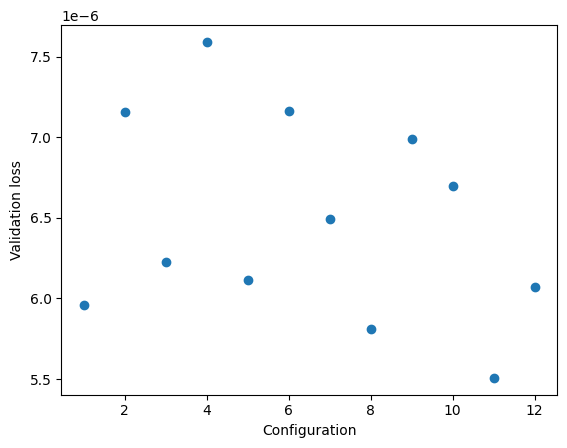

In [129]:
plt.scatter(np.arange(1,13,1), lossesvec2)
plt.xlabel('Configuration')
plt.ylabel('Validation loss')

11th configuration: 7 kernel size, 64 nodes and 32 filters.

## Latent space visualisation

In [ ]:
input_shape = (73,1)
latent_dim = 13

class Autoencoder(Model):
    def __init__(self, input_shape, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            #block1
            layers.Input(batch_shape=(None,73,1)),
            layers.Conv1D(32, kernel_size=7, activation='tanh', padding='same'),
            #block3
            layers.Conv1D(32, kernel_size=7, activation='tanh', padding='same'),
            #final
            layers.Flatten(),
            layers.Dense(64, activation='tanh'),
            layers.Dense(latent_dim, activation='tanh'),
        ])

        self.decoder = tf.keras.Sequential([
            #block1
            layers.Dense(64, activation='tanh'),
            layers.Dense(73*32, activation='tanh'),
            layers.Reshape((73,32)), 
            #block2
            layers.Conv1D(32, kernel_size=7, activation='tanh', padding='same'),
            #block3
            layers.Conv1D(32, kernel_size=7, activation='tanh', padding='same'),
            #final
            layers.Conv1D(1, kernel_size=7, activation='linear', padding='same')  
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Autoencoder(input_shape, latent_dim=latent_dim)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, min_lr=1e-12)

initial_learning_rate = 0.001
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss='mse')

optimizer = tf.keras.optimizers.Adam()


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = autoencoder.fit(train_data1, train_data1,
                          epochs=20,
                          shuffle=True,
                          batch_size=264,
                          validation_data=(val_data1, val_data1),
                           callbacks=[reduce_lr, early_stopping])

In [19]:
test_matrices = {}
n= 50
for i in range(n):
    filename = f'STARSIM_output_CCFra_{i}.txt'
    test_matrix = np.loadtxt(filename)
    test_matrices[f'd{i}'] = test_matrix
    
for i in range(n):
    test_matrices[f'd{i}'] = test_matrices[f'd{i}'][:,1:]
for i in range(n):
    test_matrices[f'd{i}'] = test_matrices[f'd{i}'].T
    

ccf_total = {}

for i in range(n):
    for j in range(73):
        a = 0
        for k in range(27):
            a += test_matrices[f'd{i}'][k,j]
        ccf_total[f'd{i}',j] = a
    

for i in range(n):
    ccf_total1 = np.zeros(73)
    for k in range(27):
        for j in range(73):
            ccf_total1[j] = ccf_total[f'd{i}',j]/27
        for l in range(73):
            test_matrices[f'd{i}'][k,l] = test_matrices[f'd{i}'][k,l]- ccf_total1[l]


for i in range(n):
    test_matrices[f'd{i}']=test_matrices[f'd{i}']/0.1
    
for i in range(n):
    test_matrices[f'd{i}'] = np.reshape(test_matrices[f'd{i}'],27*73)
    
    
test_radius = []
for i in range(50):
    test_radius.append(test_matrices[f'd{i}'])

test_radius = np.array(test_radius).reshape(n,27*73)
test_radius1 = []
for i in range(n):
    test_radius1.append(test_radius[i,0:73])
    
test_radius1 = np.array(test_radius1).reshape(n,73,1)


In [20]:
latentra = autoencoder.encoder.predict(test_radius1)

2/2 [==============================] - 0s 16ms/step


In [21]:
radius = np.arange(41,56,0.3)

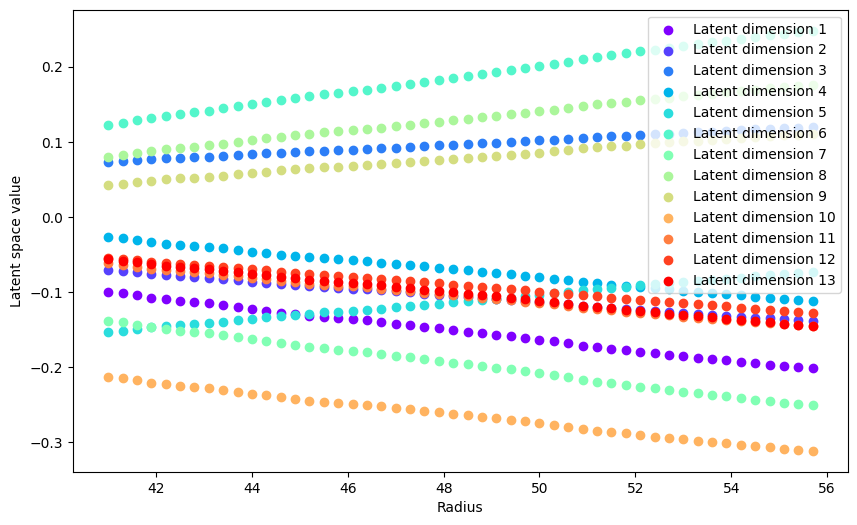

In [27]:
plt.figure(figsize=(10,6))
jet=plt.get_cmap('rainbow')
colors = iter(jet(np.linspace(0,1,13)))

plt.scatter(radius,latentra[:,0],color=next(colors), label="Latent dimension 1")
plt.scatter(radius,latentra[:,1],color=next(colors), label="Latent dimension 2")
plt.scatter(radius,latentra[:,2],color=next(colors), label="Latent dimension 3")
plt.scatter(radius,latentra[:,3],color=next(colors), label="Latent dimension 4")
plt.scatter(radius,latentra[:,4],color=next(colors), label="Latent dimension 5")
plt.scatter(radius,latentra[:,5],color=next(colors), label="Latent dimension 6")
plt.scatter(radius,latentra[:,6],color=next(colors), label="Latent dimension 7")
plt.scatter(radius,latentra[:,7],color=next(colors), label="Latent dimension 8")
plt.scatter(radius,latentra[:,8],color=next(colors), label="Latent dimension 9")
plt.scatter(radius,latentra[:,9],color=next(colors), label="Latent dimension 10")
plt.scatter(radius,latentra[:,10],color=next(colors), label="Latent dimension 11")
plt.scatter(radius,latentra[:,11],color=next(colors), label="Latent dimension 12")
plt.scatter(radius,latentra[:,12],color=next(colors), label="Latent dimension 13")


plt.xlabel("Radius")
plt.ylabel("Latent space value")
plt.legend(loc='upper right')
plt.show()